# <a title="Activity Recognition" > A demo using LSTM for Human Activity Recognition based on 3-Axis accelerometer data

This project needs two-step procedures:
(step 1) to train a 'best-trained-model' for transfer learning on the imec case dataset.
(step 2) to use the saved 'best-trained-model' to test imec case data.

This notebook covers the step 1.

## Dataset to use 
UCI machine learning repostitory 'UCI2012Acc' link:
https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones
Attribute Information:
For each record in the dataset it is provided:
- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration.
- Triaxial Angular velocity from the gyroscope.
- A 561-feature vector with time and frequency domain variables.
- Its activity label.
- An identifier of the subject who carried out the experiment.

Classifying the type of movement amongst six categories:
- WALKING,
- WALKING_UPSTAIRS,
- WALKING_DOWNSTAIRS,
- SITTING,
- STANDING,
- LAYING.

## Let's start 

In [1]:
import os
import time
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix
from utils import confusion_matrix_pd, plot_confusion_matrix
from utils import downsample_AccSignals, downsample_batch_Signals

In [2]:
print(tf.__version__)

2.2.0


## Preparing dataset:
To help you avoid the data pipeline work, I have splited the dataset (X_train, X_test, Y_train, Y_test) and stored it in a seperated file Acc_6class_UCI.pkl (~90 Mb). It will be sent to you by using 'Wetransfer' through another email. After download it, put it under the project folder 'imec_case_Acc_LSTM_demo'.


In [3]:
#%% read saved UCI Acceleromter (Acc) data
a_file = open("Acc_6class_UCI.pkl", "rb")
data = pickle.load(a_file)
a_file.close()

X_train, X_test, Y_train, Y_test = data['X_train'], data['X_test'], \
                    data['Y_train'], data['Y_test']


In [4]:
#%% use only tri-axis accelerometer data (last 3 dim)
X_train = X_train[:,:,-3:]
X_test = X_test[:,:,-3:]

Text(0.5, 1.0, 'WALK: (2.56s window)')

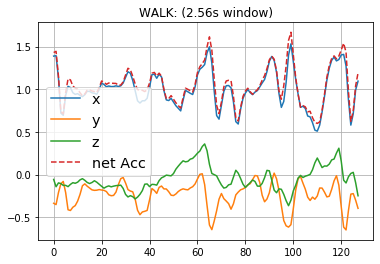

In [5]:
#%% plot Acc data
# choose an activity type to plot:
activity2plot = 0 

ACTIVITIES = {
    0: 'WALK',
    1: 'WALK_UP',
    2: 'WALK_DOWN',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING'}

Y_train_label = np.argmax(Y_train, axis=1)
locs = np.where(Y_train_label==activity2plot)[0]
# choose the first sample to plot
acc3axis_sample = X_train[locs[0]]
net_acc = np.sqrt(np.sum(acc3axis_sample**2,axis=1))
# visualize one original sample
plt.figure()
plt.plot(acc3axis_sample[:,0],label='x',linestyle='-')
plt.plot(acc3axis_sample[:,1],label='y',linestyle='-')
plt.plot(acc3axis_sample[:,2],label='z',linestyle='-')
plt.plot(net_acc,label='net Acc',linestyle='--')
plt.legend(loc='best', fontsize='x-large')
plt.grid(True)
plt.title(ACTIVITIES[activity2plot] + ': (2.56s window)')

## Downsampling the UCI2012 dataset:
for the transfer learning purpose, the sampling ratio should be the same between the two datasets. We thus need to downsampling the data from 50 Hz to 32 Hz (used for imec case).

Text(0.5, 1.0, 'WALK : downsampling (2.56s window)')

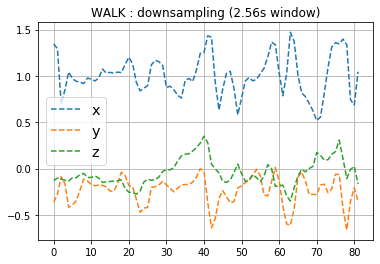

In [6]:
# visualize the above sample after downsampling
num_downsample = 82 # 82/32 = 2.5625 sec ~ 2.56 sec used for UCI data
acc3axis_sample2 = downsample_AccSignals(acc3axis_sample, num_downsample)
plt.figure()
plt.plot(acc3axis_sample2[:,0],label='x',linestyle='--')
plt.plot(acc3axis_sample2[:,1],label='y',linestyle='--')
plt.plot(acc3axis_sample2[:,2],label='z',linestyle='--')
plt.legend(loc='best', fontsize='x-large')
plt.grid(True)
plt.title(ACTIVITIES[activity2plot] + ' : downsampling (2.56s window)')

It works well, so let's downsampling the whole dataset

In [7]:
#%% downsampling all X data for transfer learning, to match 32 Hz sampling ratio
num_downsample = 82 # 82/32 = 2.5625 sec ~ 2.56 sec used for UCI data 
X_train = downsample_batch_Signals(X_train,num_downsample)
X_test = downsample_batch_Signals(X_test,num_downsample)


## Let's build the LSTM neural net:

Different models use the output units in different ways. Common combinations include sequence-to-one (input a sequence, create a single output), sequence-to-sequence (input a sequence, then create another sequence as output), and synced sequence to sequence which pipelines the output. A visualisation tool for RNNs has been recently developed. See [this blog](https://blog.acolyer.org/2019/02/25/understanding-hidden-memories-of-recurrent-neural-networks/). 

<img src="images/schemes of RNN.png" style="width:300;height:200px;">

Two common RNN variants are long short-term memory (LSTM) networks and Gated Recurrent Units (GRUs). LSTM is more complex, but easier to train, avoiding what is called the vanishing gradient problem. I recommend [this article](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) to learn more on LSTMs. This project is the case (a) shown in above figure. You can find other applications using LSTM in my [GitHub page](https://github.com/ieeeWang?tab=repositories) such as LSTM_sentiment (a), LSTM_translate_attention (b) and LSTM_Jazz (c).

In [8]:
#%% define network LSTM
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = 6
n_hidden = 32

model = models.Sequential()
model.add(layers.LSTM(n_hidden, input_shape=(timesteps, input_dim)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(n_classes, activation='sigmoid'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4608      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 198       
Total params: 4,806
Trainable params: 4,806
Non-trainable params: 0
_________________________________________________________________


In [9]:
#%% define the training loop for saving the best trained model
def train_network(network, x_training, y_training, x_validation, y_validation, 
                  n_epoch, batch_size, network_save_path):

    # lists where we will be storing values during training
    tra_losses = [] # list for training loss
    tra_accs = [] # list for training accuracy
    val_losses = [] # list for validation loss
    val_accs = [] # list for validation accuracy
    
    # we want to save the parameters that give the best performance on the validation set
    # so we store the best validation accuracy, and save the parameters to disk
    best_validation_accuracy = 0 # best validation accuracy
    
    for epoch in range(n_epoch):  
        print('epoch:',epoch,'/',n_epoch)
        # Train the network
        results = network.fit(x_training, y_training, epochs=1, batch_size = batch_size)
        
        # Get training loss and accuracy
        training_loss = results.history['loss']
        training_accuracy = results.history['accuracy']
        # Add to list
        tra_losses.append(training_loss)
        tra_accs.append(training_accuracy)
        
        # Evaluate performance (loss and accuracy) on validation set
        scores = network.evaluate(x_validation, y_validation, batch_size = batch_size)
        validation_loss = scores[0]
        validation_accuracy = scores[1]
        # Add to list
        val_losses.append(validation_loss)
        val_accs.append(validation_accuracy)
        
        # (Possibly) update best validation accuracy and save the network
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            network.save(model_path)
            print('Saved trained model at %s ' % model_path)

    # for Visualization of the learning curves
    return tra_losses, tra_accs, val_losses, val_accs

Before starting training, choose the path for saving the trained models:

In [10]:
# choose the path for saving the trained models
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'LSTM_best_trained_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
model_path = os.path.join(save_dir, model_name)


## Let's train the LSTM neural net:

epoch: 0 / 20
185/185 [==============================] - 1s 4ms/step - loss: 1.2410 - accuracy: 0.4293
Saved trained model at C:\Users\lwang\Documents\DL\ACC\imec_case_Acc_LSTM_demo\saved_models\LSTM_best_trained_model.h5 
epoch: 1 / 20
185/185 [==============================] - 1s 4ms/step - loss: 1.2452 - accuracy: 0.4323
Saved trained model at C:\Users\lwang\Documents\DL\ACC\imec_case_Acc_LSTM_demo\saved_models\LSTM_best_trained_model.h5 
epoch: 2 / 20
185/185 [==============================] - 1s 4ms/step - loss: 1.3859 - accuracy: 0.3821
epoch: 3 / 20
185/185 [==============================] - 1s 4ms/step - loss: 1.2719 - accuracy: 0.4903
Saved trained model at C:\Users\lwang\Documents\DL\ACC\imec_case_Acc_LSTM_demo\saved_models\LSTM_best_trained_model.h5 
epoch: 4 / 20
185/185 [==============================] - 1s 4ms/step - loss: 1.1868 - accuracy: 0.5042
Saved trained model at C:\Users\lwang\Documents\DL\ACC\imec_case_Acc_LSTM_demo\saved_models\LSTM_best_trained_model.h5 
epoch

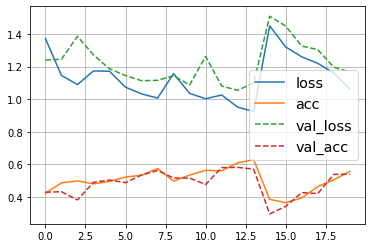

In [11]:
n_epoch = 20
batch_size= 16 # best < 16
start_time = time.time()

tra_losses, tra_accs, val_losses, val_accs = train_network(model, X_train, 
                     Y_train, X_test, Y_test, n_epoch, batch_size, model_path)

print('elapsed_time:',  time.time() - start_time) # ~517 s for 100 epochs

# visualize the learning curves after training done
plt.figure()
plt.plot(tra_losses,label='loss',linestyle='-')
plt.plot(tra_accs,label='acc',linestyle='-')
plt.plot(val_losses,label='val_loss',linestyle='--')
plt.plot(val_accs,label='val_acc',linestyle='--')
plt.legend(loc='best', fontsize='x-large')
plt.grid(True)

## Evaluate the saved 'best model':

Accuracy: 58.19%


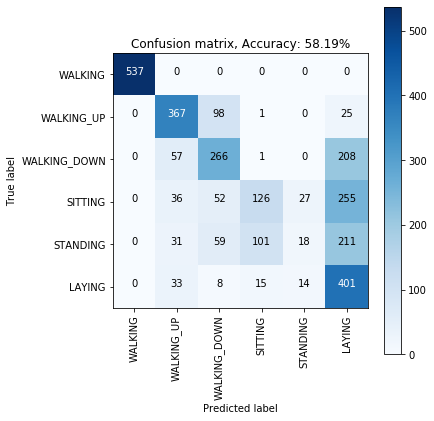

In [12]:
# Re-load the model with the best validation accuracy
# use the previousely saved model (after runing 100 epochs)
model_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'LSTM_best_trained_model_3Acc_32Hz_90.1.h5'
# model_path = os.path.join(model_dir, model_name)

# use the saved model after runing previous steps
best_model= keras.models.load_model(model_path)
y_pre = best_model.predict(X_test)

# plt.figure()
# plt.plot(y_pre[:,3],label='pred',linestyle='-')

Y_true = [ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)]
Y_pred = [ACTIVITIES[y] for y in np.argmax(y_pre, axis=1)]

# get overall accuracy
accuracy = accuracy_score(Y_true, Y_pred)
print ('Accuracy: {:.2f}%'.format(100.0*accuracy))
# confusion matrix
conf_mat = confusion_matrix(Y_true, Y_pred)
# visualize the confusion matrix
activityTypes = ['WALKING', 'WALKING_UP', 'WALKING_DOWN', 'SITTING', 'STANDING', 'LAYING']
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_mat, classes=activityTypes, 
                      title='Confusion matrix, Accuracy: {:.2f}%'.format(100.0*accuracy))


The above performance can be further improved by increase the training epochs, so that the better trained model is saved. We have already got one better model using 100 training epochs. Now we can test it.

Accuracy: 90.06%


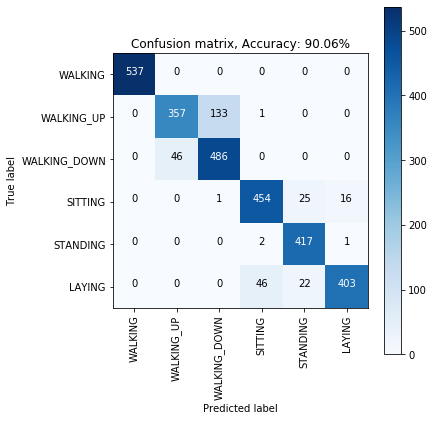

In [13]:
# Re-load the model with the best validation accuracy
# use the previousely saved model (after runing 100 epochs)
model_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'LSTM_best_trained_model_3Acc_32Hz_90.1.h5'
model_path = os.path.join(model_dir, model_name)

# use the saved model after runing previous steps
best_model= keras.models.load_model(model_path)
y_pre = best_model.predict(X_test)

# plt.figure()
# plt.plot(y_pre[:,3],label='pred',linestyle='-')

Y_true = [ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)]
Y_pred = [ACTIVITIES[y] for y in np.argmax(y_pre, axis=1)]

# get overall accuracy
accuracy = accuracy_score(Y_true, Y_pred)
print ('Accuracy: {:.2f}%'.format(100.0*accuracy))
# confusion matrix
conf_mat = confusion_matrix(Y_true, Y_pred)
# visualize the confusion matrix
activityTypes = ['WALKING', 'WALKING_UP', 'WALKING_DOWN', 'SITTING', 'STANDING', 'LAYING']
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_mat, classes=activityTypes, 
                      title='Confusion matrix, Accuracy: {:.2f}%'.format(100.0*accuracy))


## Conclusion:

I specially did not expect such good results for guessing between the labels "SITTING" and "STANDING". Those are seemingly almost the same thing from the point of view of a device placed at waist level according to how the dataset was originally gathered. Thought, it is still possible to see a little cluster on the matrix between those classes, which drifts away just a bit from the identity. This is great.

It is not surprising to notice many misclassifications between "WALKING_UP" and "WALKING_DOWN". It is because, for both "WALKING_UP" and "WALKING_DOWN", each step including both an acceleration phase and a decelerating phase but in opposite order, which yield a ‘S’ curve in one dimension. Check this vedio for more details (https://www.youtube.com/watch?v=MAR4yvxQpzc) However, a sliding window will miss such ‘order’ information and both patterns will seem highly similar. Plus, it is different to estimate the ‘order’ information if the orientation of mounted accelerometer is unknown (which is different from studies to studies).